In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
import xgboost as xgb
import lightgbm as lgb
import catboost
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
import matplotlib.gridspec as gridspec
%matplotlib inline

# Standard plotly imports
import chart_studio.plotly as py
import plotly.graph_objs as go
import plotly.tools as tls
from plotly.offline import iplot, init_notebook_mode
# import cufflinks
# import cufflinks as cf
# import plotly.figure_factory as ff

# # Using plotly + cufflinks in offline mode
# init_notebook_mode(connected=True)
# cufflinks.go_offline(connected=True)


import warnings
warnings.filterwarnings("ignore")

import gc
gc.enable()

import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

import os
folder_path = '../data/IEEE-CIS-Fraud-Detection/'

print(os.listdir(folder_path))

# Any results you write to the current directory are saved as output.
print ("Ready!")

['test_identity.csv', 'ieee-gb-2-make-amount-useful-again_train.pkl', 'merge_two_csv.ipynb', 'test_identity.csv.zip', 'lgb-single-model-lb-0-9419_test.pkl', 'extensive-eda-and-modeling-xgb-hyperopt_train.pkl', 'test.csv', 'eda-and-models_test.pkl', 'train_identity_fixed.pkl', 'test_transaction_fixed.pkl', 'almost-complete-feature-engineering-ieee-data_train.pkl', 'almost-complete-feature-engineering-ieee-data_test.pkl', 'test_identity.pkl', 'train_transaction.pkl', 'sample_submission.csv', 'train_transaction.csv', 'train_transaction.csv.zip', 'extensive-eda-and-modeling-xgb-hyperopt_test.pkl', 'feature-engineering-lightgbm_test.pkl', 'fraud-complete-eda_train.pkl', 'test_transaction.csv', 'feature-engineering-lightgbm_train.pkl', 'sample_submission.csv.zip', 'test_identity_fixed.pkl', 'lgb-single-model-lb-0-9419_train.pkl', '.DS_Store', 'train_identity.csv.zip', 'df_train.gzde', 'train_identity.pkl', 'train_transaction_fixed.pkl', '.ipynb_checkpoints', 'train_identity.csv', 'df_test.gz

In [2]:
# functions from: https://www.kaggle.com/kabure/baseline-fraud-detection-eda-interactive-views

def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

def plot_distribution(df, var_select=None, title=None, bins=1.0): 
    # Calculate the correlation coefficient between the new variable and the target
    tmp_fraud = df[df['isFraud'] == 1]
    tmp_no_fraud = df[df['isFraud'] == 0]    
    corr = df['isFraud'].corr(df[var_select])
    corr = np.round(corr,3)
    tmp1 = tmp_fraud[var_select].dropna()
    tmp2 = tmp_no_fraud[var_select].dropna()
    hist_data = [tmp1, tmp2]
    
    group_labels = ['Fraud', 'No Fraud']
    colors = ['seagreen','indianred', ]

    fig = ff.create_distplot(hist_data,
                             group_labels,
                             colors = colors, 
                             show_hist = True,
                             curve_type='kde', 
                             bin_size = bins
                            )
    
    fig['layout'].update(title = title+' '+'(corr target ='+ str(corr)+')')

    iplot(fig, filename = 'Density plot')
    
def plot_dist_churn(df, col, binary=None):
    tmp_churn = df[df[binary] == 1]
    tmp_no_churn = df[df[binary] == 0]
    tmp_attr = round(tmp_churn[col].value_counts().sort_index() / df[col].value_counts().sort_index(),2)*100
    print(f'Distribution of {col}: ')
    trace1 = go.Bar(
        x=tmp_churn[col].value_counts().sort_index().index,
        y=tmp_churn[col].value_counts().sort_index().values, 
        name='Fraud',opacity = 0.8, marker=dict(
            color='seagreen',
            line=dict(color='#000000',width=1)))

    trace2 = go.Bar(
        x=tmp_no_churn[col].value_counts().sort_index().index,
        y=tmp_no_churn[col].value_counts().sort_index().values,
        name='No Fraud', opacity = 0.8, 
        marker=dict(
            color='indianred',
            line=dict(color='#000000',
                      width=1)
        )
    )

    trace3 =  go.Scatter(   
        x=tmp_attr.sort_index().index,
        y=tmp_attr.sort_index().values,
        yaxis = 'y2', 
        name='% Fraud', opacity = 0.6, 
        marker=dict(
            color='black',
            line=dict(color='#000000',
                      width=2 )
        )
    )
    
    layout = dict(title =  f'Distribution of {str(col)} feature by %Fraud',
              xaxis=dict(type='category'), 
              yaxis=dict(title= 'Count'), 
              yaxis2=dict(range= [0, 15], 
                          overlaying= 'y', 
                          anchor= 'x', 
                          side= 'right',
                          zeroline=False,
                          showgrid= False, 
                          title= 'Percentual Fraud Transactions'
                         ))

    fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
    iplot(fig)

In [3]:
print('# File sizes')
for f in os.listdir(folder_path):
    if 'zip' not in f:
        print(f.ljust(30) + str(round(os.path.getsize(f'{folder_path}{f}') / 1000000, 2)) + 'MB')

# File sizes
test_identity.csv             25.8MB
ieee-gb-2-make-amount-useful-again_train.pkl96.6MB
merge_two_csv.ipynb           0.0MB
lgb-single-model-lb-0-9419_test.pkl62.86MB
extensive-eda-and-modeling-xgb-hyperopt_train.pkl20.47MB
test.csv                      652.63MB
eda-and-models_test.pkl       75.66MB
train_identity_fixed.pkl      15.89MB
test_transaction_fixed.pkl    665.17MB
almost-complete-feature-engineering-ieee-data_train.pkl31.6MB
almost-complete-feature-engineering-ieee-data_test.pkl27.12MB
test_identity.pkl             14.84MB
train_transaction.pkl         529.71MB
sample_submission.csv         6.08MB
train_transaction.csv         683.35MB
extensive-eda-and-modeling-xgb-hyperopt_test.pkl18.38MB
feature-engineering-lightgbm_test.pkl62.83MB
fraud-complete-eda_train.pkl  57.09MB
test_transaction.csv          613.19MB
feature-engineering-lightgbm_train.pkl69.97MB
test_identity_fixed.pkl       15.69MB
lgb-single-model-lb-0-9419_train.pkl71.09MB
.DS_Store                 

In [4]:
%%time
train_transaction = pd.read_csv(f'{folder_path}train_transaction.csv', index_col='TransactionID')
test_transaction = pd.read_csv(f'{folder_path}test_transaction.csv', index_col='TransactionID')
train_identity = pd.read_csv(f'{folder_path}train_identity.csv', index_col='TransactionID')
test_identity = pd.read_csv(f'{folder_path}test_identity.csv', index_col='TransactionID')
print ("Data is loaded!")

Data is loaded!
CPU times: user 23.6 s, sys: 1.61 s, total: 25.2 s
Wall time: 25.2 s


In [5]:
print('train_transaction shape is {}'.format(train_transaction.shape))
print('test_transaction shape is {}'.format(test_transaction.shape))
print('train_identity shape is {}'.format(train_identity.shape))
print('test_identity shape is {}'.format(test_identity.shape))

train_transaction shape is (590540, 393)
test_transaction shape is (506691, 392)
train_identity shape is (144233, 40)
test_identity shape is (141907, 40)


In [6]:
train_transaction.head()

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
train_identity.head()

,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [8]:
missing_values_count = train_transaction.isnull().sum()
print (missing_values_count[0:10])
total_cells = np.product(train_transaction.shape)
total_missing = missing_values_count.sum()
print ("% of missing data = ",(total_missing/total_cells) * 100)

isFraud              0
TransactionDT        0
TransactionAmt       0
ProductCD            0
card1                0
card2             8933
card3             1565
card4             1577
card5             4259
card6             1571
dtype: int64
% of missing data =  41.17794374769424


In [9]:
missing_values_count = train_identity.isnull().sum()
print (missing_values_count[0:10])
total_cells = np.product(train_identity.shape)
total_missing = missing_values_count.sum()
print ("% of missing data = ",(total_missing/total_cells) * 100)

id_01         0
id_02      3361
id_03     77909
id_04     77909
id_05      7368
id_06      7368
id_07    139078
id_08    139078
id_09     69307
id_10     69307
dtype: int64
% of missing data =  36.47062392101669


In [10]:
del missing_values_count, total_cells, total_missing

In [11]:
# x = train_transaction['isFraud'].value_counts().index
# y = train_transaction['isFraud'].value_counts().values

# trace2 = go.Bar(
#      x=x ,
#      y=y,
#      marker=dict(
#          color=y,
#          colorscale = 'Viridis',
#          reversescale = True
#      ),
#      name="Imbalance",    
#  )
# layout = dict(
#      title="Data imbalance - isFraud",
#      #width = 900, height = 500,
#      xaxis=go.layout.XAxis(
#      automargin=True),
#      yaxis=dict(
#          showgrid=False,
#          showline=False,
#          showticklabels=True,
#  #         domain=[0, 0.85],
#      ), 
# )
# fig1 = go.Figure(data=[trace2], layout=layout)
# iplot(fig1)

In [12]:
del x,y
gc.collect()

NameError: name 'x' is not defined

In [13]:
# Here we confirm that all of the transactions in `train_identity`
print(np.sum(train_transaction.index.isin(train_identity.index.unique())))
print(np.sum(test_transaction.index.isin(test_identity.index.unique())))

144233
141907


In [14]:
train_transaction['TransactionDT'].head()

TransactionID
2987000    86400
2987001    86401
2987002    86469
2987003    86499
2987004    86506
Name: TransactionDT, dtype: int64

In [15]:
train_transaction['TransactionDT'].shape[0] , train_transaction['TransactionDT'].nunique()

(590540, 573349)

In [16]:
train_transaction['TransactionDT'].value_counts().head(10)

9474817     8
11576951    5
7236588     5
4397066     5
8468062     4
8020359     4
7337054     4
5334992     4
1971839     4
1962054     4
Name: TransactionDT, dtype: int64

In [17]:
train_transaction.head()

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
# i = 'isFraud'
# cor = np.corrcoef(train_transaction['TransactionDT'], train_transaction[i])[0,1]
# train_transaction.loc[train_transaction['isFraud'] == 0].set_index('TransactionDT')[i].plot(style='.', title=i+" corr= "+str(round(cor,3)), figsize=(15, 3), label="isFraud=0")
# train_transaction.loc[train_transaction['isFraud'] == 1].set_index('TransactionDT')[i].plot(style='.', title=i+" corr= "+str(round(cor,3)), figsize=(15, 3), label="isFraud=1")
# #test_transaction.set_index('TransactionDT')[i].plot(style='.', title=i+" corr= "+str(round(cor,3)), figsize=(15, 3))
# plt.legend()
# plt.show()

In [19]:
# c_features = list(train_transaction.columns[16:30])
# for i in c_features:
#     cor = np.corrcoef(train_transaction['TransactionDT'], train_transaction[i])[0,1]
#     train_transaction.set_index('TransactionDT')[i].plot(style='.', title=i+" corr= "+str(round(cor,3)), figsize=(15, 3))
#     test_transaction.set_index('TransactionDT')[i].plot(style='.', title=i+" corr= "+str(round(cor,3)), figsize=(15, 3))
#     plt.show()

In [20]:
# c_features = list(train_transaction.columns[16:30])
# for i in c_features:
#     cor = np.corrcoef(train_transaction['TransactionDT'], train_transaction[i])[0,1]
#     train_transaction.set_index('TransactionDT')[i].plot(style='.', title=i+" corr= "+str(round(cor,3)), figsize=(15, 3))
#     test_transaction.set_index('TransactionDT')[i].plot(style='.', title=i+" corr= "+str(round(cor,3)), figsize=(15, 3))
#     plt.show()

In [21]:
# del c_features
# gc.collect()

In [22]:
d_features = list(train_transaction.columns[30:45])

# for i in d_features:
#     cor = np.corrcoef(train_transaction['TransactionDT'], train_transaction[i])[0,1]
#     train_transaction.set_index('TransactionDT')[i].plot(style='.', title=i+" corr= "+str(round(cor,3)), figsize=(15, 3))
#     test_transaction.set_index('TransactionDT')[i].plot(style='.', title=i+" corr= "+str(round(cor,3)), figsize=(15, 3))
#     plt.show()

In [23]:
train_transaction[d_features].head()

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15
TransactionID,,,,,,,,,,,,,,,
2987000,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0
2987001,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0
2987002,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,315.0,NaN,NaN,NaN,315.0
2987003,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,84.0,NaN,NaN,NaN,NaN,111.0
2987004,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
# Click output to see the number of missing values in each column
missing_values_count = train_transaction[d_features].isnull().sum()
missing_values_count

D1       1269
D2     280797
D3     262878
D4     168922
D5     309841
D6     517353
D7     551623
D8     515614
D9     515614
D10     76022
D11    279287
D12    525823
D13    528588
D14    528353
D15     89113
dtype: int64

In [25]:
# how many total missing values do we have?
total_cells = np.product(train_transaction[d_features].shape)
total_missing = missing_values_count.sum()
# percent of data that is missing
(total_missing/total_cells) * 100

58.15126268612908

In [26]:
# for i in d_features:
#     cor_tr = np.corrcoef(train_transaction['TransactionDT'], train_transaction[i].fillna(-1))[0,1]
#     cor_te = np.corrcoef(test_transaction['TransactionDT'], test_transaction[i].fillna(-1))[0,1]
#     train_transaction.set_index('TransactionDT')[i].fillna(-1).plot(style='.', title=i+" corr_tr= "+str(round(cor_tr,3))+" || corr_te= "+str(round(cor_te,3)), figsize=(15, 3))
#     test_transaction.set_index('TransactionDT')[i].fillna(-1).plot(style='.', title=i+" corr_tr= "+str(round(cor_tr,3))+"  || corr_te= "+str(round(cor_te,3)), figsize=(15, 3))
#     plt.show()

In [27]:
# del d_features, cor
# gc.collect()

In [28]:
m_features = list(train_transaction.columns[45:54])
train_transaction[m_features].head()

,M1,M2,M3,M4,M5,M6,M7,M8,M9
TransactionID,,,,,,,,,
2987000,T,T,T,M2,F,T,NaN,NaN,NaN
2987001,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN
2987002,T,T,T,M0,F,F,F,F,F
2987003,NaN,NaN,NaN,M0,T,F,NaN,NaN,NaN
2987004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
# del m_features
# gc.collect()

In [30]:
# i = "V150"
# cor_tr = np.corrcoef(train_transaction['TransactionDT'], train_transaction[i].fillna(-1))[0,1]
# cor_te = np.corrcoef(test_transaction['TransactionDT'], test_transaction[i].fillna(-1))[0,1]
# train_transaction.set_index('TransactionDT')[i].fillna(-1).plot(style='.', title=i+" corr_tr= "+str(round(cor_tr,3))+" || corr_te= "+str(round(cor_te,3)), figsize=(15, 3))
# test_transaction.set_index('TransactionDT')[i].fillna(-1).plot(style='.', title=i+" corr_tr= "+str(round(cor_tr,3))+"  || corr_te= "+str(round(cor_te,3)), figsize=(15, 3))
# plt.show()

In [31]:
train_transaction.loc[:,train_transaction.columns[train_transaction.columns.str.startswith('V')]].isnull().sum().head(20)

V1     279287
V2     279287
V3     279287
V4     279287
V5     279287
V6     279287
V7     279287
V8     279287
V9     279287
V10    279287
V11    279287
V12     76073
V13     76073
V14     76073
V15     76073
V16     76073
V17     76073
V18     76073
V19     76073
V20     76073
dtype: int64

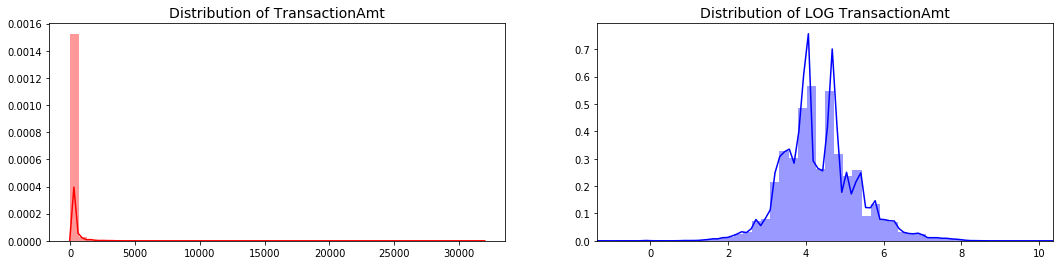

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

time_val = train_transaction['TransactionAmt'].values

sns.distplot(time_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of TransactionAmt', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

sns.distplot(np.log(time_val), ax=ax[1], color='b')
ax[1].set_title('Distribution of LOG TransactionAmt', fontsize=14)
ax[1].set_xlim([min(np.log(time_val)), max(np.log(time_val))])

plt.show()

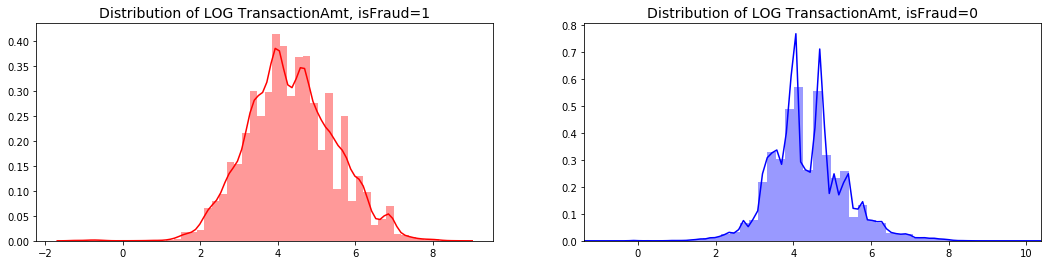

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

time_val = train_transaction.loc[train_transaction['isFraud'] == 1]['TransactionAmt'].values

sns.distplot(np.log(time_val), ax=ax[0], color='r')
ax[0].set_title('Distribution of LOG TransactionAmt, isFraud=1', fontsize=14)
ax[1].set_xlim([min(np.log(time_val)), max(np.log(time_val))])

time_val = train_transaction.loc[train_transaction['isFraud'] == 0]['TransactionAmt'].values

sns.distplot(np.log(time_val), ax=ax[1], color='b')
ax[1].set_title('Distribution of LOG TransactionAmt, isFraud=0', fontsize=14)
ax[1].set_xlim([min(np.log(time_val)), max(np.log(time_val))])


plt.show()

In [34]:
del time_val

In [35]:
# tmp = train_transaction[['TransactionAmt', 'isFraud']][0:100000]
# plot_distribution(tmp[(tmp['TransactionAmt'] <= 800)], 'TransactionAmt', 'Transaction Amount Distribution', bins=10.0,)
# del tmp

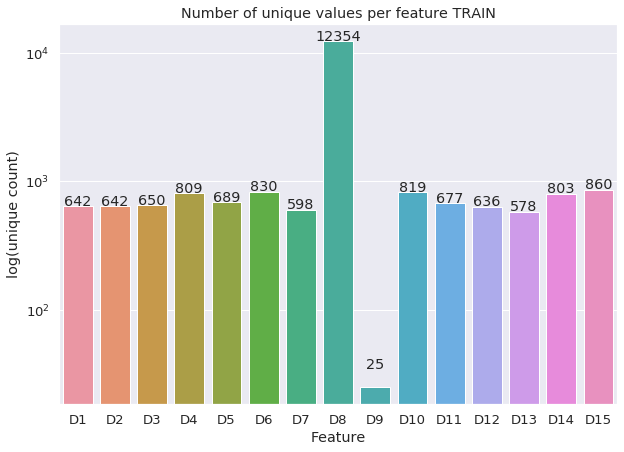

In [36]:
plt.figure(figsize=(10, 7))
d_features = list(train_transaction.columns[30:45])
uniques = [len(train_transaction[col].unique()) for col in d_features]
sns.set(font_scale=1.2)
ax = sns.barplot(d_features, uniques, log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique values per feature TRAIN')
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            uniq,
            ha="center") 

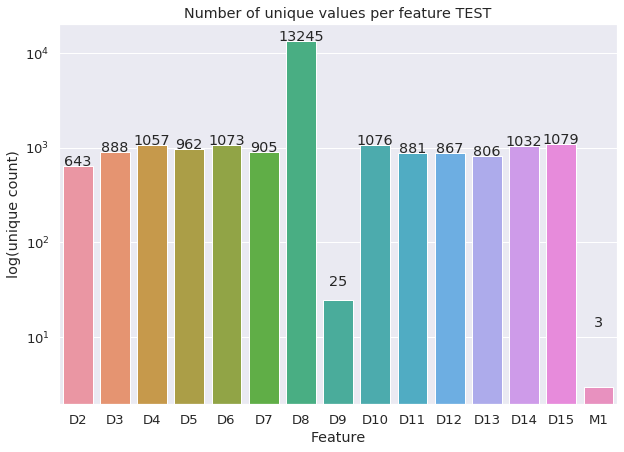

In [37]:
plt.figure(figsize=(10, 7))
d_features = list(test_transaction.columns[30:45])
uniques = [len(test_transaction[col].unique()) for col in d_features]
sns.set(font_scale=1.2)
ax = sns.barplot(d_features, uniques, log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique values per feature TEST')
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            uniq,
            ha="center") 

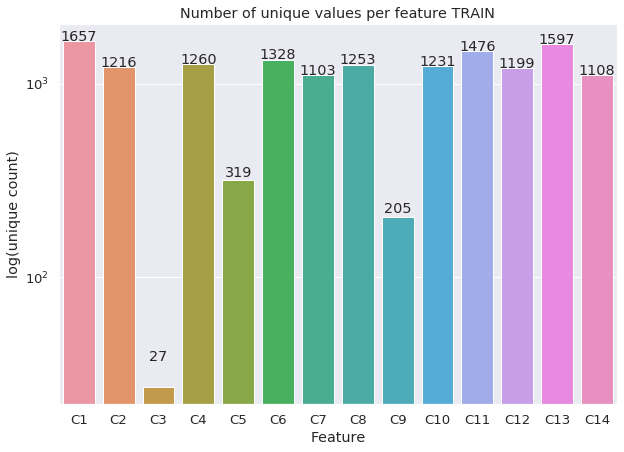

In [38]:
plt.figure(figsize=(10, 7))
c_features = list(train_transaction.columns[16:30])
uniques = [len(train_transaction[col].unique()) for col in c_features]
sns.set(font_scale=1.2)
ax = sns.barplot(c_features, uniques, log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique values per feature TRAIN')
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            uniq,
            ha="center") 

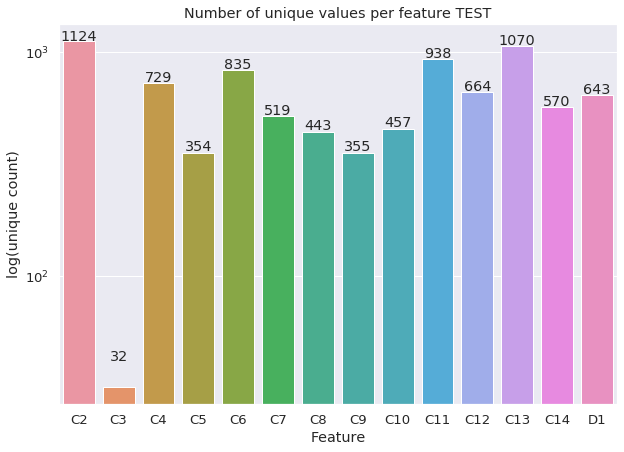

In [39]:
plt.figure(figsize=(10, 7))
c_features = list(test_transaction.columns[16:30])
uniques = [len(test_transaction[col].unique()) for col in c_features]
sns.set(font_scale=1.2)
ax = sns.barplot(c_features, uniques, log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique values per feature TEST')
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            uniq,
            ha="center") 

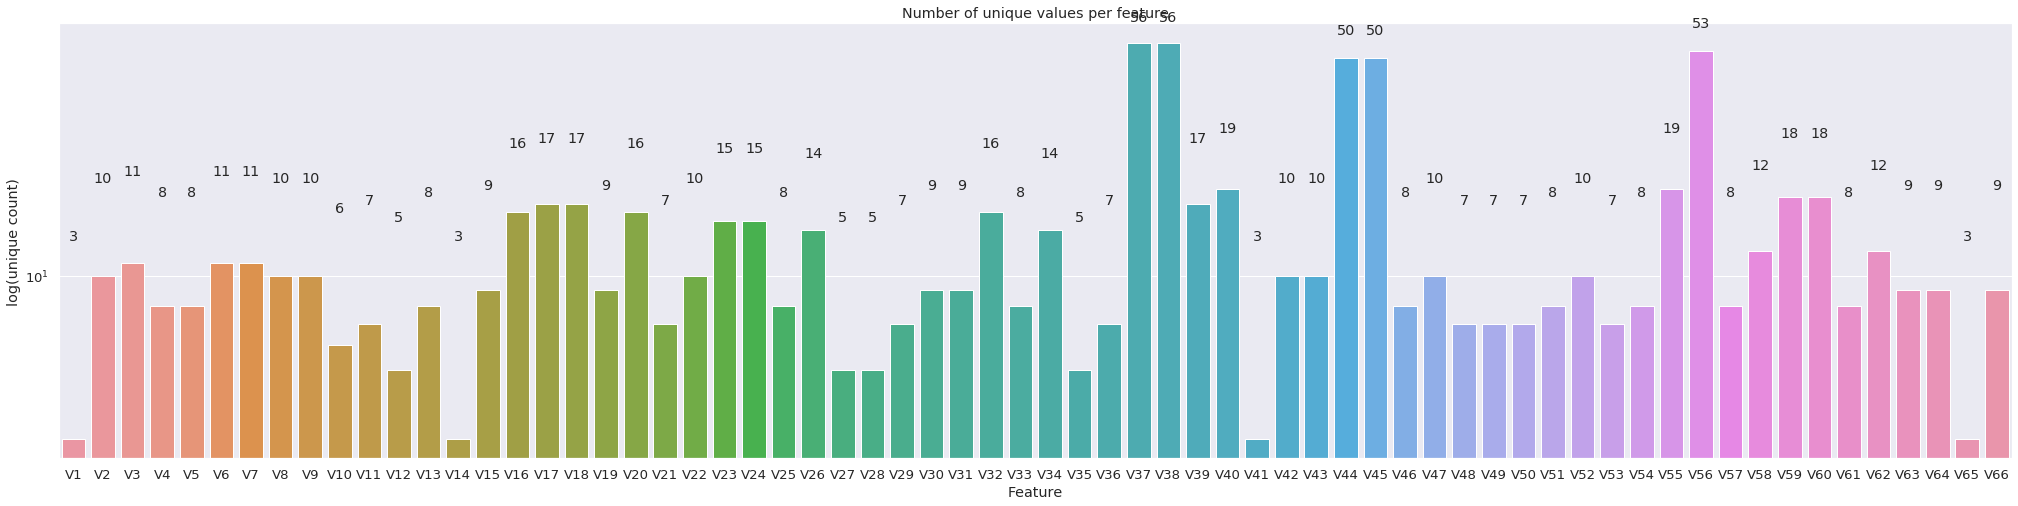

In [40]:
plt.figure(figsize=(35, 8))
v_features = list(train_transaction.columns[54:120])
uniques = [len(train_transaction[col].unique()) for col in v_features]
sns.set(font_scale=1.2)
ax = sns.barplot(v_features, uniques, log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique values per feature')
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            uniq,
            ha="center") 

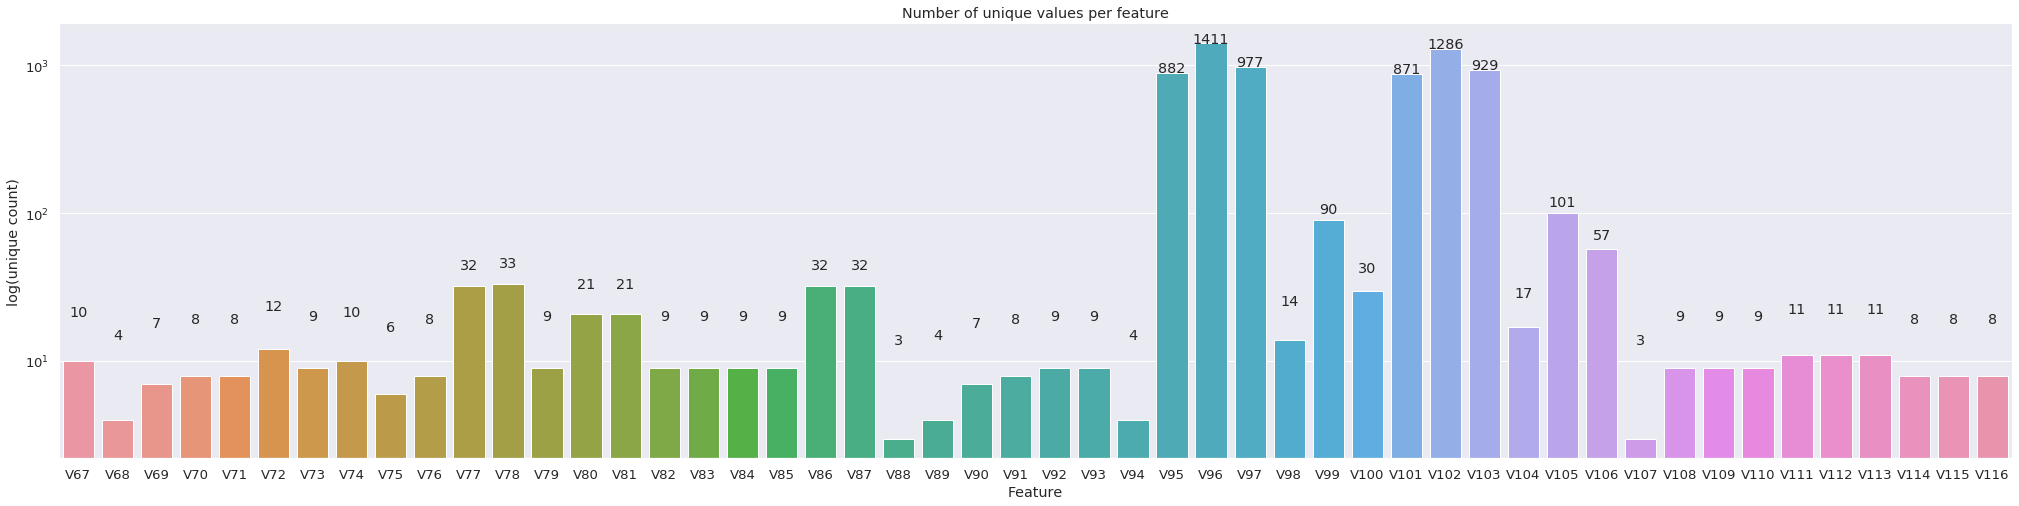

In [41]:
plt.figure(figsize=(35, 8))
v_features = list(train_transaction.columns[120:170])
uniques = [len(train_transaction[col].unique()) for col in v_features]
sns.set(font_scale=1.2)
ax = sns.barplot(v_features, uniques, log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique values per feature')
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            uniq,
            ha="center") 

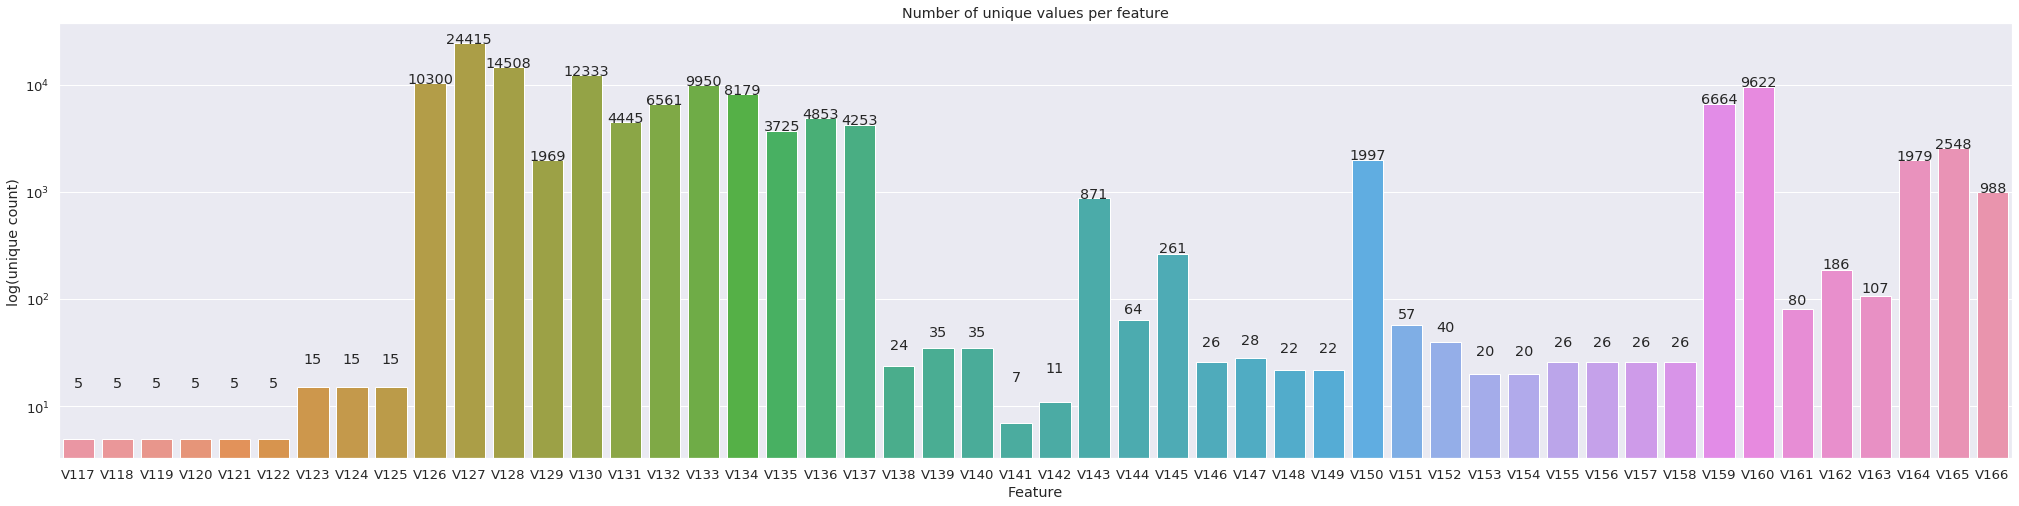

In [42]:
plt.figure(figsize=(35, 8))
v_features = list(train_transaction.columns[170:220])
uniques = [len(train_transaction[col].unique()) for col in v_features]
sns.set(font_scale=1.2)
ax = sns.barplot(v_features, uniques, log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique values per feature')
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            uniq,
            ha="center") 

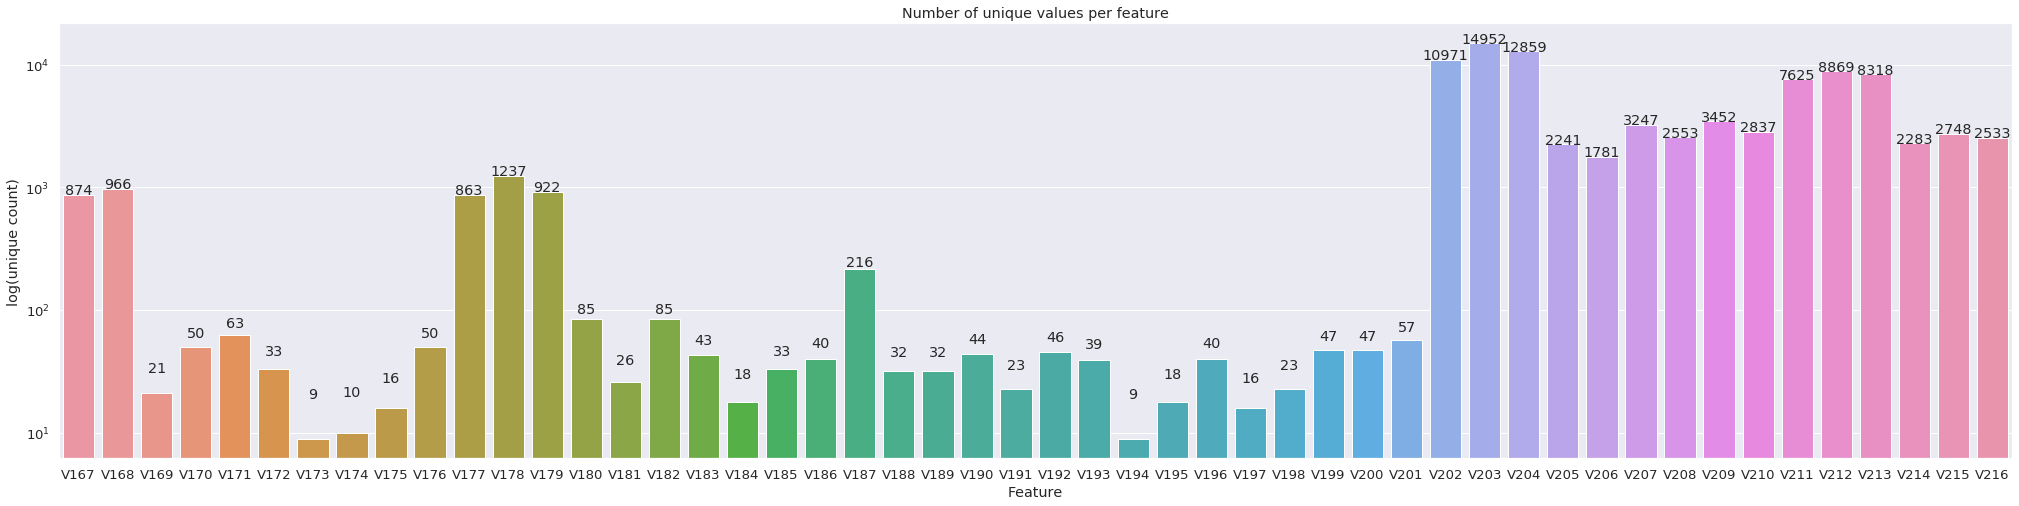

In [43]:
plt.figure(figsize=(35, 8))
v_features = list(train_transaction.columns[220:270])
uniques = [len(train_transaction[col].unique()) for col in v_features]
sns.set(font_scale=1.2)
ax = sns.barplot(v_features, uniques, log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique values per feature')
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            uniq,
            ha="center") 

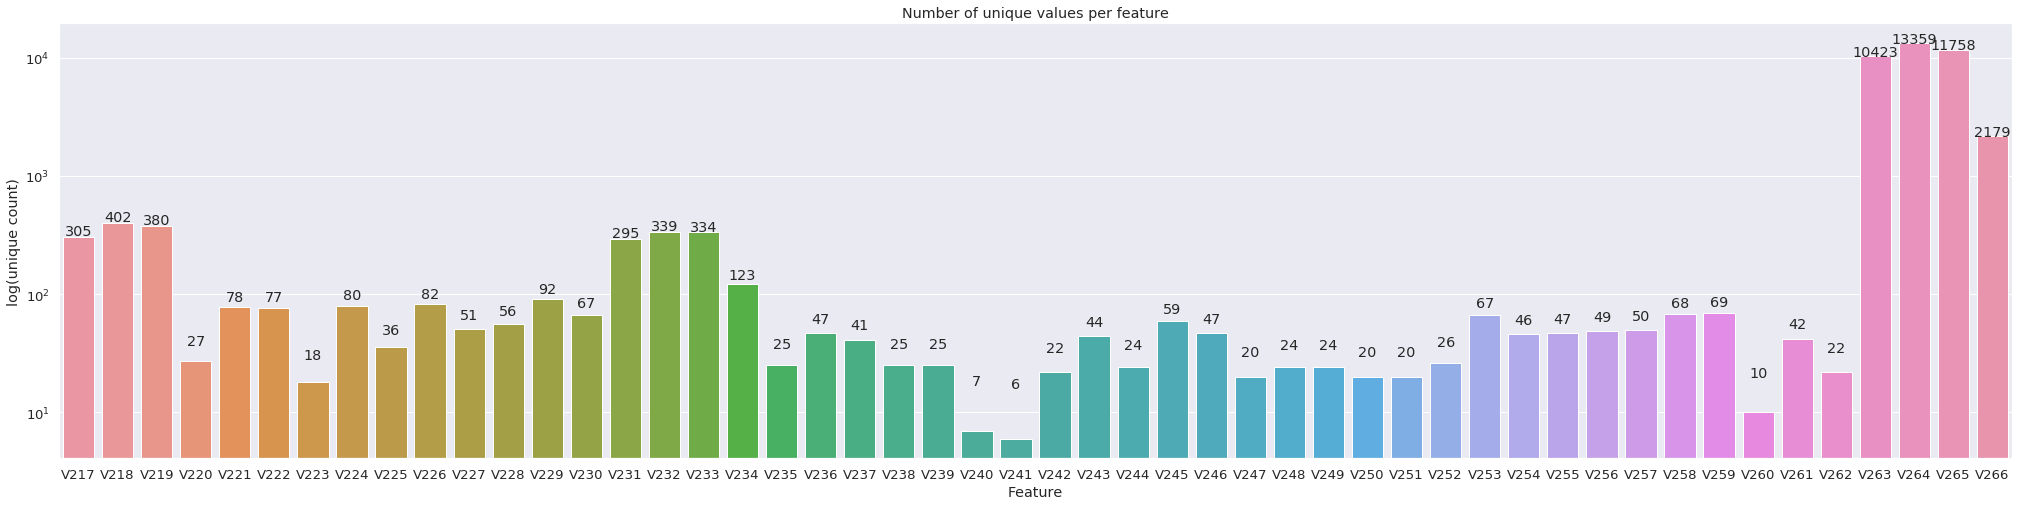

In [44]:
plt.figure(figsize=(35, 8))
v_features = list(train_transaction.columns[270:320])
uniques = [len(train_transaction[col].unique()) for col in v_features]
sns.set(font_scale=1.2)
ax = sns.barplot(v_features, uniques, log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique values per feature')
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            uniq,
            ha="center") 

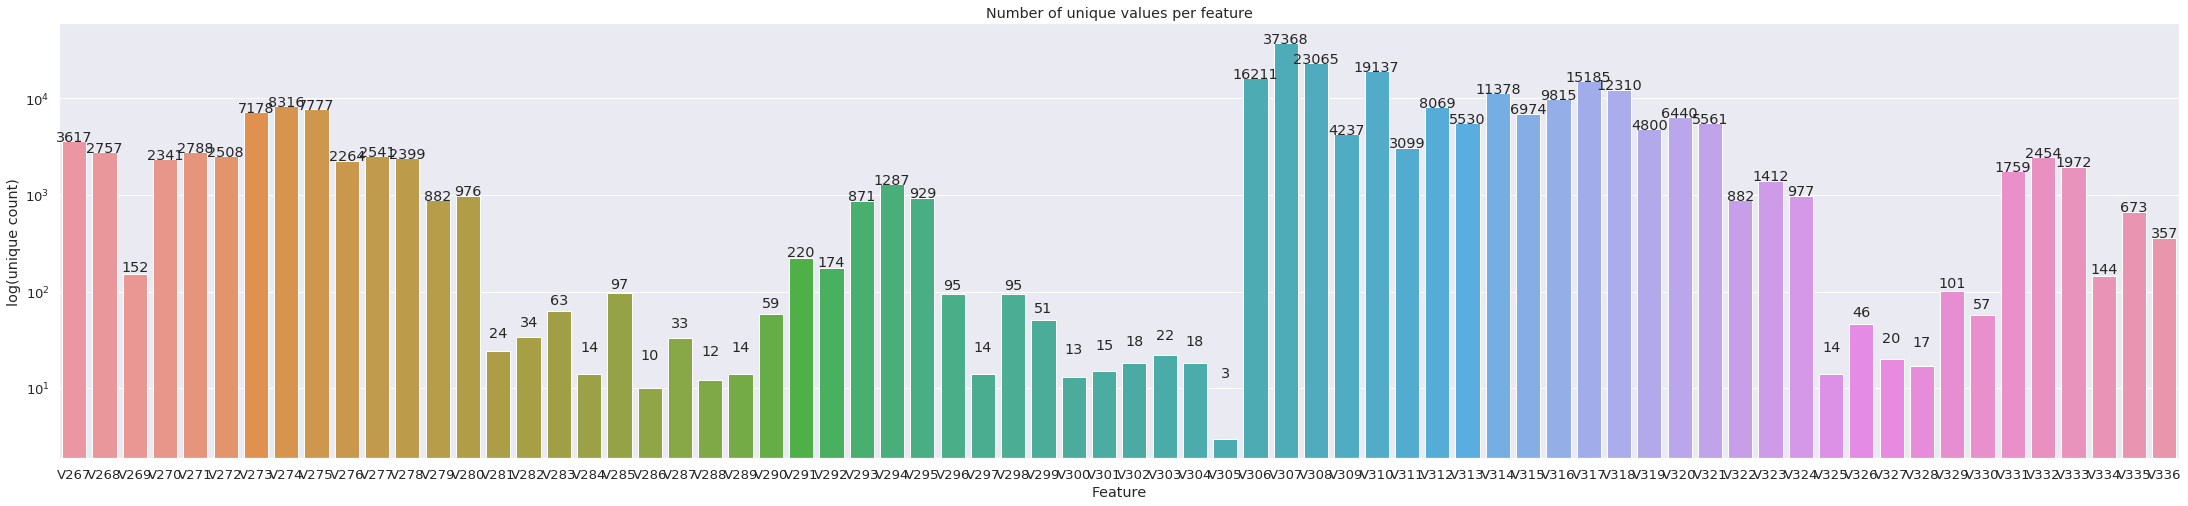

In [45]:
plt.figure(figsize=(38, 8))
v_features = list(train_transaction.columns[320:390])
uniques = [len(train_transaction[col].unique()) for col in v_features]
sns.set(font_scale=1.2)
ax = sns.barplot(v_features, uniques, log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique values per feature')
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            uniq,
            ha="center") 

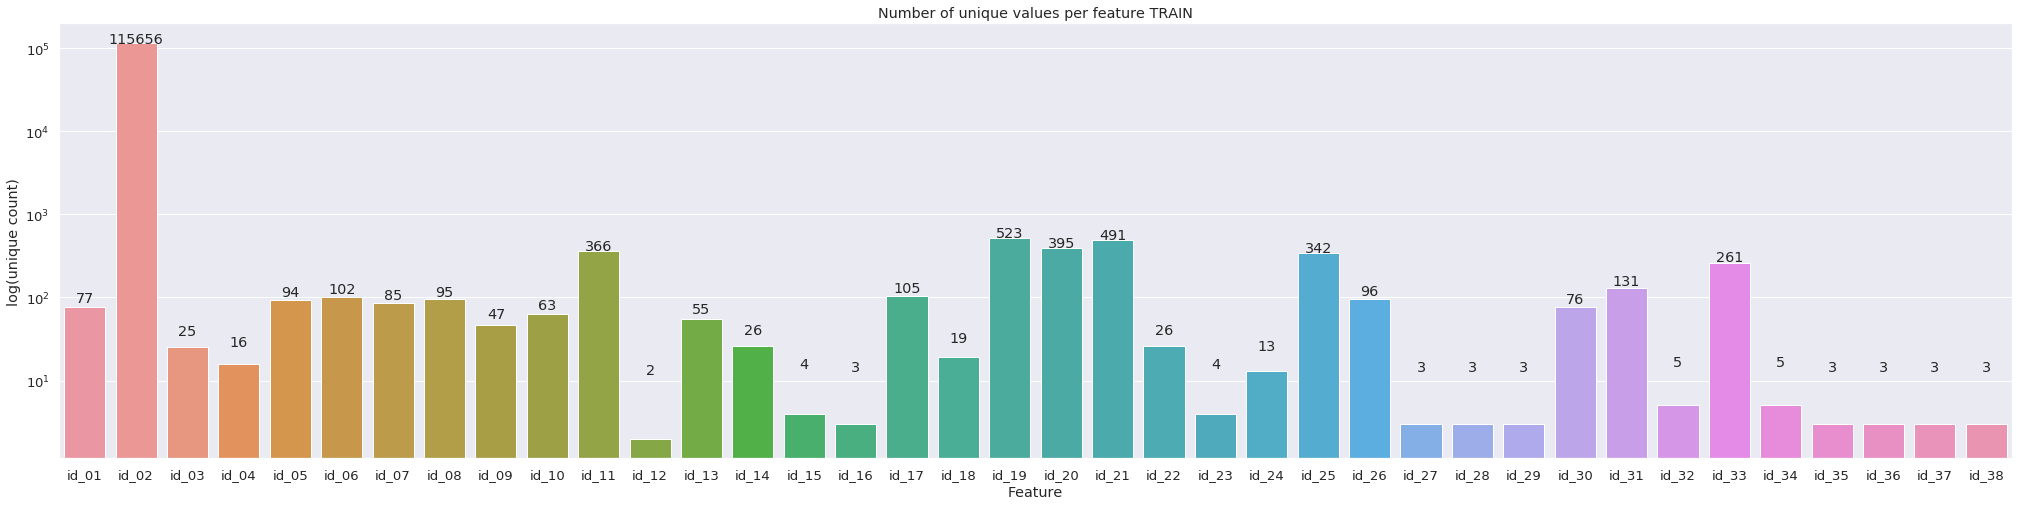

In [46]:
plt.figure(figsize=(35, 8))
features = list(train_identity.columns[0:38])
uniques = [len(train_identity[col].unique()) for col in features]
sns.set(font_scale=1.2)
ax = sns.barplot(features, uniques, log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique values per feature TRAIN')
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            uniq,
            ha="center") 

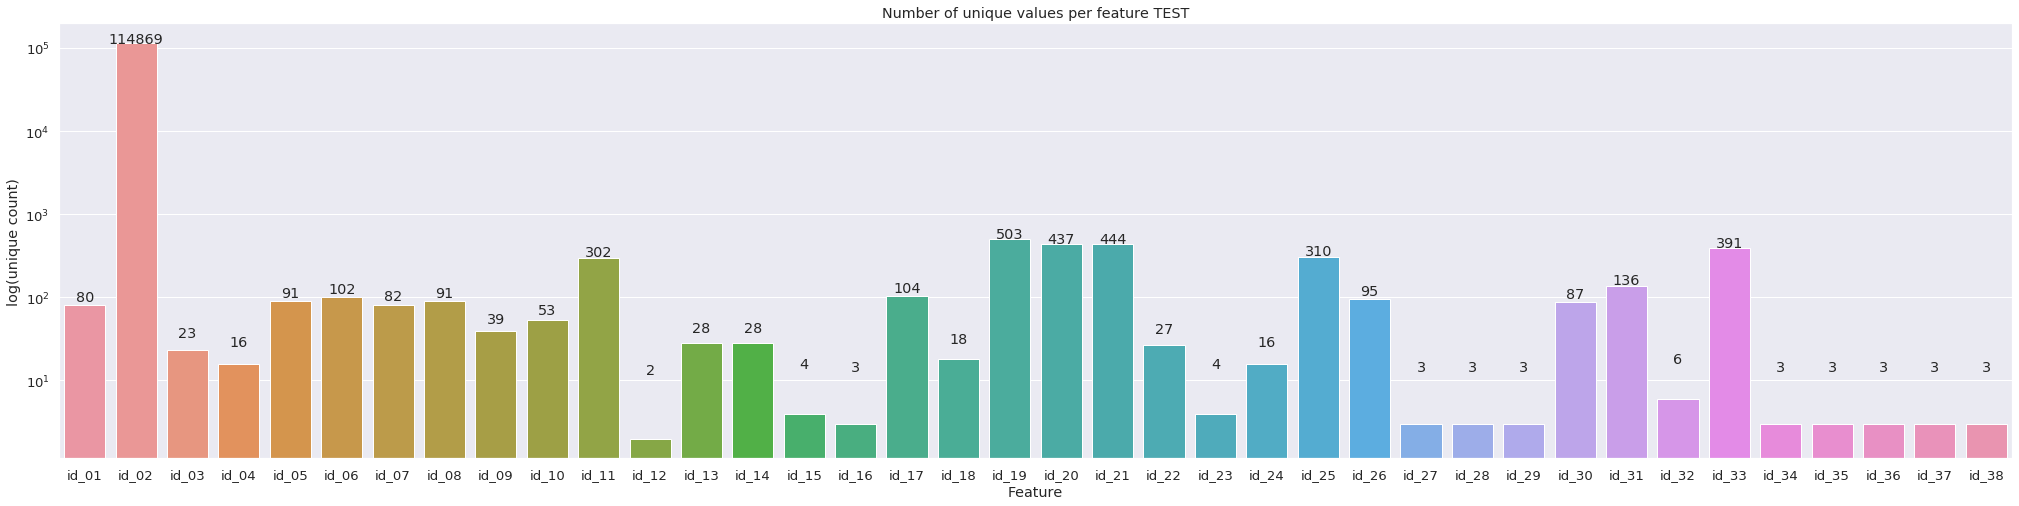

In [47]:
plt.figure(figsize=(35, 8))
features = list(test_identity.columns[0:38])
uniques = [len(test_identity[col].unique()) for col in features]
sns.set(font_scale=1.2)
ax = sns.barplot(features, uniques, log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique values per feature TEST')
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            uniq,
            ha="center") 

In [48]:
train_transaction.head(3)

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
train_identity.head(3)

,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows


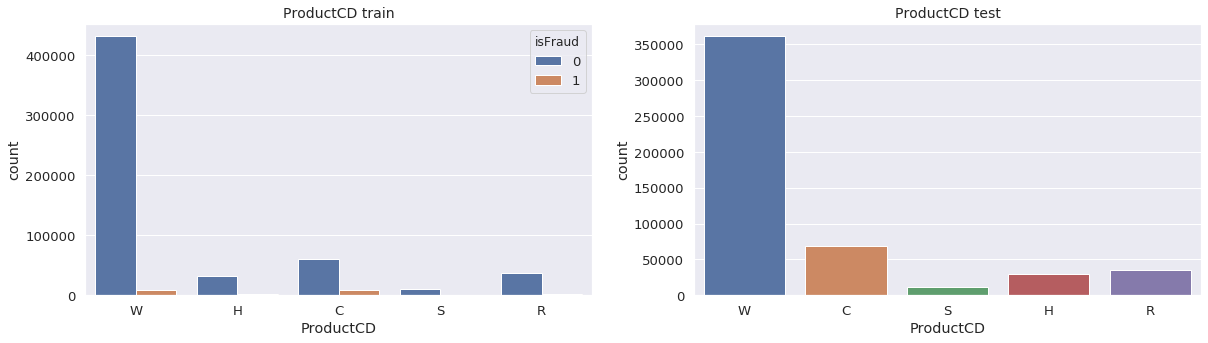

In [50]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))

sns.countplot(x="ProductCD", ax=ax[0], hue = "isFraud", data=train_transaction)
ax[0].set_title('ProductCD train', fontsize=14)
sns.countplot(x="ProductCD", ax=ax[1], data=test_transaction)
ax[1].set_title('ProductCD test', fontsize=14)
plt.show()

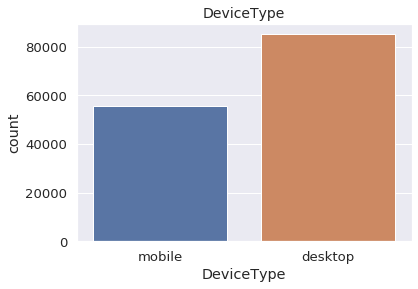

In [51]:
ax = sns.countplot(x="DeviceType", data=train_identity)
ax.set_title('DeviceType', fontsize=14)
plt.show()

In [52]:
print ("Unique Devices = ",train_identity['DeviceInfo'].nunique())
train_identity['DeviceInfo'].value_counts().head()

Unique Devices =  1786


Windows        47722
iOS Device     19782
MacOS          12573
Trident/7.0     7440
rv:11.0         1901
Name: DeviceInfo, dtype: int64

In [53]:
cards = ['card1', 'card2', 'card3', 'card4', 'card5', 'card6']
for i in cards:
    print ("Unique ",i, " = ",train_transaction[i].nunique())

Unique  card1  =  13553
Unique  card2  =  500
Unique  card3  =  114
Unique  card4  =  4
Unique  card5  =  119
Unique  card6  =  4


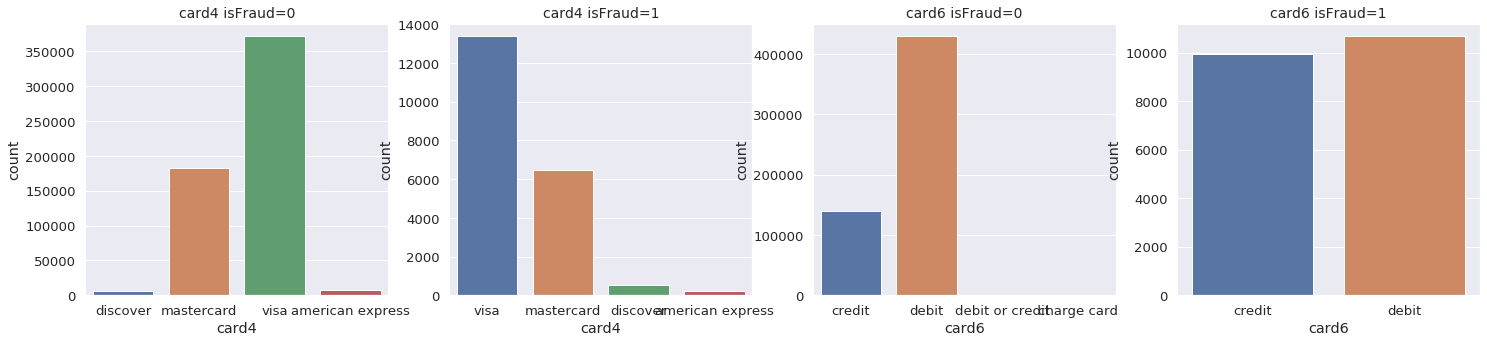

In [54]:
fig, ax = plt.subplots(1, 4, figsize=(25,5))

sns.countplot(x="card4", ax=ax[0], data=train_transaction.loc[train_transaction['isFraud'] == 0])
ax[0].set_title('card4 isFraud=0', fontsize=14)
sns.countplot(x="card4", ax=ax[1], data=train_transaction.loc[train_transaction['isFraud'] == 1])
ax[1].set_title('card4 isFraud=1', fontsize=14)
sns.countplot(x="card6", ax=ax[2], data=train_transaction.loc[train_transaction['isFraud'] == 0])
ax[2].set_title('card6 isFraud=0', fontsize=14)
sns.countplot(x="card6", ax=ax[3], data=train_transaction.loc[train_transaction['isFraud'] == 1])
ax[3].set_title('card6 isFraud=1', fontsize=14)
plt.show()

In [55]:
# cards = train_transaction.iloc[:,4:7].columns

# plt.figure(figsize=(18,8*4))
# gs = gridspec.GridSpec(8, 4)
# for i, cn in enumerate(cards):
#     ax = plt.subplot(gs[i])
#     sns.distplot(train_transaction.loc[train_transaction['isFraud'] == 1][cn], bins=50)
#     sns.distplot(train_transaction.loc[train_transaction['isFraud'] == 0][cn], bins=50)
#     ax.set_xlabel('')
#     ax.set_title('feature: ' + str(cn))
# plt.show()

In [56]:
"emaildomain" in train_transaction.columns, "emaildomain" in train_identity.columns

(False, False)

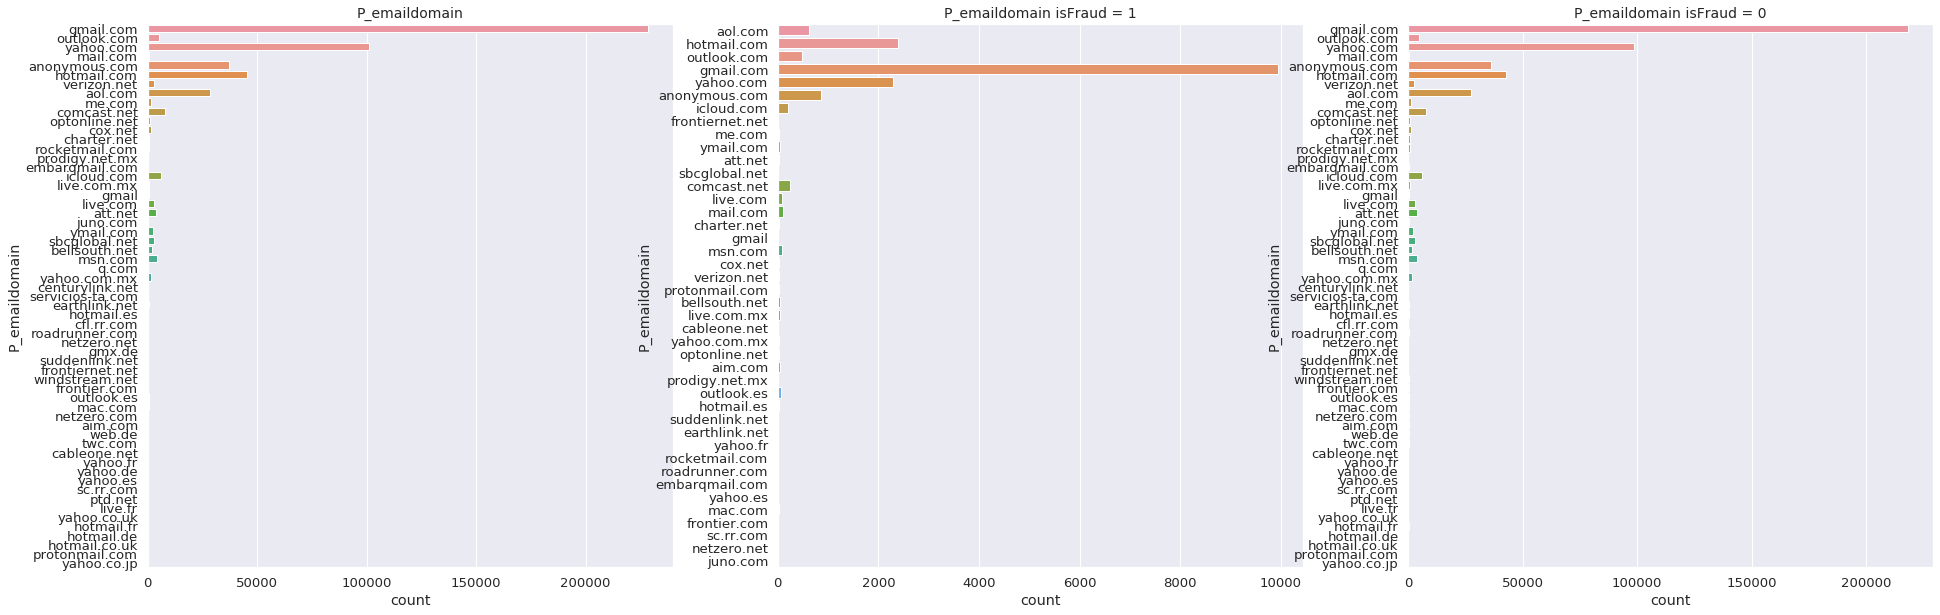

In [57]:
fig, ax = plt.subplots(1, 3, figsize=(32,10))

sns.countplot(y="P_emaildomain", ax=ax[0], data=train_transaction)
ax[0].set_title('P_emaildomain', fontsize=14)
sns.countplot(y="P_emaildomain", ax=ax[1], data=train_transaction.loc[train_transaction['isFraud'] == 1])
ax[1].set_title('P_emaildomain isFraud = 1', fontsize=14)
sns.countplot(y="P_emaildomain", ax=ax[2], data=train_transaction.loc[train_transaction['isFraud'] == 0])
ax[2].set_title('P_emaildomain isFraud = 0', fontsize=14)
plt.show()

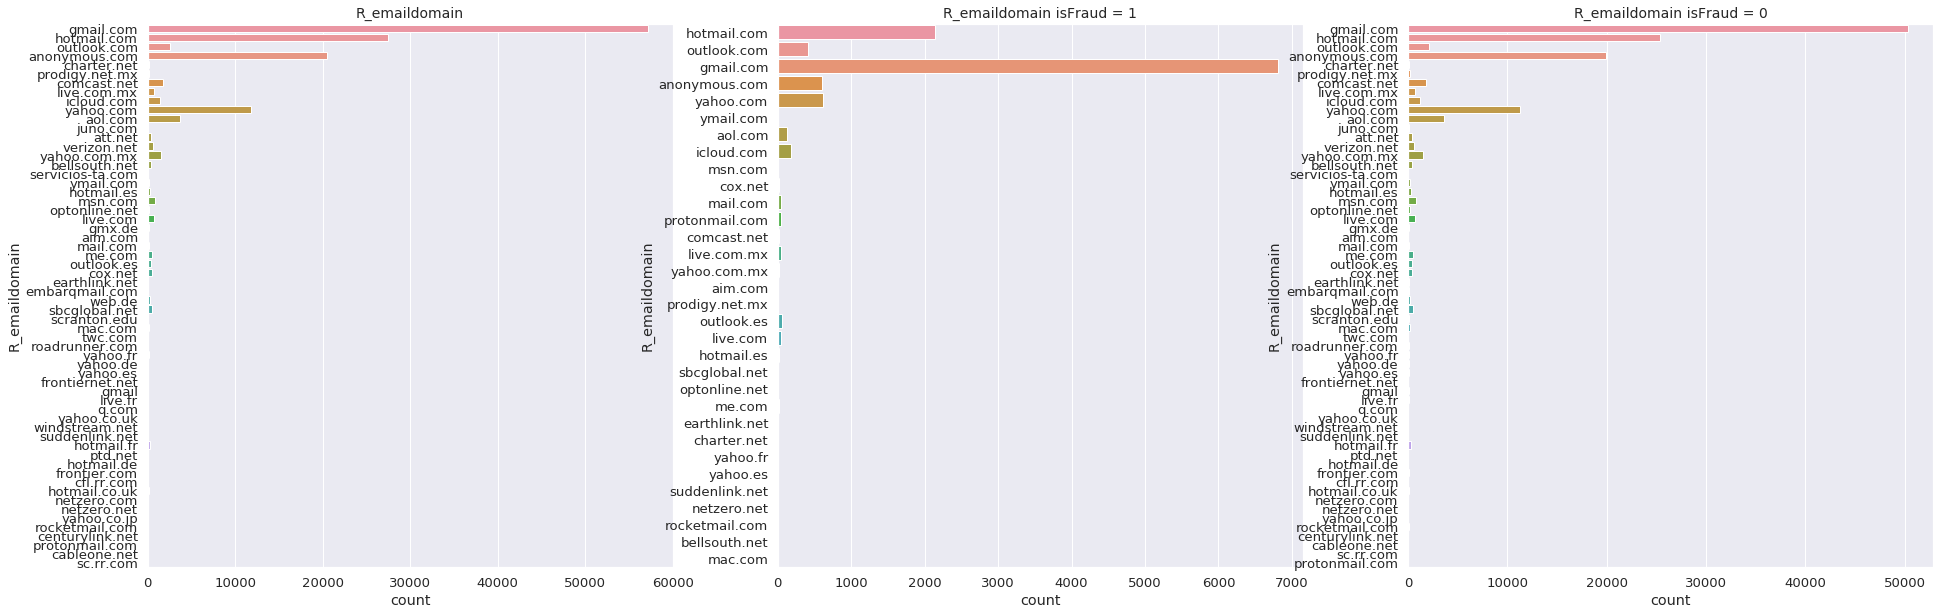

In [58]:
fig, ax = plt.subplots(1, 3, figsize=(32,10))

sns.countplot(y="R_emaildomain", ax=ax[0], data=train_transaction)
ax[0].set_title('R_emaildomain', fontsize=14)
sns.countplot(y="R_emaildomain", ax=ax[1], data=train_transaction.loc[train_transaction['isFraud'] == 1])
ax[1].set_title('R_emaildomain isFraud = 1', fontsize=14)
sns.countplot(y="R_emaildomain", ax=ax[2], data=train_transaction.loc[train_transaction['isFraud'] == 0])
ax[2].set_title('R_emaildomain isFraud = 0', fontsize=14)
plt.show()

In [59]:
%%time
train = train_transaction.merge(train_identity, how='left', left_index=True, right_index=True)
y_train = train['isFraud'].astype("uint8").copy()
print("Tain: ",train.shape)
del train_transaction, train_identity

test = test_transaction.merge(test_identity, how='left', left_index=True, right_index=True)
print("Test: ",test.shape)
del test_transaction, test_identity
print ("Merged!")

Tain:  (590540, 433)
Test:  (506691, 432)
Merged!
CPU times: user 1.67 s, sys: 857 ms, total: 2.53 s
Wall time: 2.52 s


In [60]:
%%time
X_train = train.drop('isFraud', axis=1)
X_test = test.copy()

del train, test
gc.collect()

# Label Encoding
for f in X_train.columns:
    if X_train[f].dtype=='object' or X_test[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(X_train[f].values) + list(X_test[f].values))
        X_train[f] = lbl.transform(list(X_train[f].values))
        X_test[f] = lbl.transform(list(X_test[f].values))  

CPU times: user 49.2 s, sys: 6.05 s, total: 55.3 s
Wall time: 55.3 s


In [61]:
def reduce_mem_usage1(props):
    start_mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in props.columns:
        if props[col].dtype != object:  # Exclude strings
            
            # Print current column type
            print("******************************")
            print("Column: ",col)
            print("dtype before: ",props[col].dtype)
            
            # make variables for Int, max and min
            IsInt = False
            mx = props[col].max()
            mn = props[col].min()
            
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(props[col]).all(): 
                NAlist.append(col)
                props[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = props[col].fillna(0).astype(np.int64)
            result = (props[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True

            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        props[col] = props[col].astype(np.uint8)
                    elif mx < 65535:
                        props[col] = props[col].astype(np.uint16)
                    elif mx < 4294967295:
                        props[col] = props[col].astype(np.uint32)
                    else:
                        props[col] = props[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        props[col] = props[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        props[col] = props[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        props[col] = props[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        props[col] = props[col].astype(np.int64)    
            
            # Make float datatypes 32 bit
            else:
                props[col] = props[col].astype(np.float32)
            
            # Print new column type
            print("dtype after: ",props[col].dtype)
            print("******************************")
    
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return props, NAlist

In [62]:
%%time
# From kernel https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
# WARNING! THIS CAN DAMAGE THE DATA 
def reduce_mem_usage2(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 4.29 µs


In [63]:
%%time
X_train = reduce_mem_usage2(X_train)
X_test = reduce_mem_usage2(X_test)

Memory usage of dataframe is 1970.87 MB
Memory usage after optimization is: 547.14 MB
Decreased by 72.2%
Memory usage of dataframe is 1673.87 MB
Memory usage after optimization is: 460.02 MB
Decreased by 72.5%
CPU times: user 1min 7s, sys: 2min 13s, total: 3min 21s
Wall time: 3min 21s


In [64]:
X_train.head(3)

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,86400,68.5,4,13926,NaN,150.0,1,142.0,1,315.0,...,136,NaN,461,4,2,2,2,2,2,2740
2987001,86401,29.0,4,2755,404.0,150.0,2,102.0,1,325.0,...,136,NaN,461,4,2,2,2,2,2,2740
2987002,86469,59.0,4,4663,490.0,150.0,4,166.0,2,330.0,...,136,NaN,461,4,2,2,2,2,2,2740


In [65]:
X_test.head(3)

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,
3663549,18403224,31.953125,4,10409,111.0,150.0,4,226.0,2,170.0,...,136,NaN,461,4,2,2,2,2,2,2740
3663550,18403263,49.000000,4,4272,111.0,150.0,4,226.0,2,299.0,...,136,NaN,461,4,2,2,2,2,2,2740
3663551,18403310,171.000000,4,4476,574.0,150.0,4,226.0,2,472.0,...,136,NaN,461,4,2,2,2,2,2,2740


In [66]:
X_train.columns.tolist()

['TransactionDT',
 'TransactionAmt',
 'ProductCD',
 'card1',
 'card2',
 'card3',
 'card4',
 'card5',
 'card6',
 'addr1',
 'addr2',
 'dist1',
 'dist2',
 'P_emaildomain',
 'R_emaildomain',
 'C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'D1',
 'D2',
 'D3',
 'D4',
 'D5',
 'D6',
 'D7',
 'D8',
 'D9',
 'D10',
 'D11',
 'D12',
 'D13',
 'D14',
 'D15',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'V29',
 'V30',
 'V31',
 'V32',
 'V33',
 'V34',
 'V35',
 'V36',
 'V37',
 'V38',
 'V39',
 'V40',
 'V41',
 'V42',
 'V43',
 'V44',
 'V45',
 'V46',
 'V47',
 'V48',
 'V49',
 'V50',
 'V51',
 'V52',
 'V53',
 'V54',
 'V55',
 'V56',
 'V57',
 'V58',
 'V59',
 'V60',
 'V61',
 'V62',
 'V63',
 'V64',
 'V65',
 'V66',
 'V67',
 'V68',
 

In [67]:
X_train['TransactionID'] = X_train.index
X_train = X_train.reset_index(drop=True)

In [68]:
X_test['TransactionID'] = X_test.index
X_test = X_test.reset_index(drop=True)

In [69]:
X_train.shape, X_test.shape

((590540, 433), (506691, 433))

In [70]:
import sys
sys.path.append("..") # Adds higher directory to python modules path.
from kaggleKID.preprocessing import check_dataframe

df_train, df_test, diff_type_cols, not_numbic_cols, na_existed_cols, all_na_cols, trn_tst_imbalance_col = check_dataframe(X_train, X_test,['TransactionID','TransactionDT'])

train V130 is float16 and test V130 is float32
train V131 is float16 and test V131 is float32
train V159 is float16 and test V159 is float32
train V207 is float16 and test V207 is float32
train V273 is float16 and test V273 is float32
train V275 is float16 and test V275 is float32
train V310 is float16 and test V310 is float32
train V312 is float16 and test V312 is float32
card2 8933 8654 float16 [100.0, 100.0] [600.0, 600.0]
card3 1565 3002 float16 [100.0, 100.0] [231.0, 232.0]
card5 4259 4547 float16 [100.0, 100.0] [237.0, 237.0]
addr1 65706 65609 float16 [100.0, 100.0] [540.0, 540.0]
addr2 65706 65609 float16 [10.0, 10.0] [102.0, 102.0]
dist1 352271 291217 float16 [0.0, 0.0] [10290.0, 8080.0]
dist2 552913 470255 float16 [0.0, 0.0] [11624.0, 9220.0]
C1 0 3 float16 [0.0, 0.0] [4684.0, 2950.0]
C2 0 3 float16 [0.0, 0.0] [5692.0, 3276.0]
C3 0 3 float16 [0.0, 0.0] [26.0, 31.0]
C4 0 3 float16 [0.0, 0.0] [2252.0, 1601.0]
C5 0 3 float16 [0.0, 0.0] [349.0, 376.0]
C6 0 3 float16 [0.0, 0.0] [22

V144 508589 430636 float16 [0.0, 0.0] [62.0, 85.0]
V145 508589 430636 float16 [0.0, 0.0] [297.0, 279.0]
V146 508595 430906 float16 [0.0, 0.0] [24.0, 12.0]
V147 508595 430906 float16 [0.0, 0.0] [26.0, 22.0]
V148 508595 430906 float16 [0.0, 0.0] [20.0, 11.0]
V149 508595 430906 float16 [0.0, 0.0] [20.0, 11.0]
V150 508589 430636 float16 [1.0, 1.0] [3388.0, 2276.0]
V151 508589 430636 float16 [1.0, 1.0] [57.0, 58.0]
V152 508589 430636 float16 [1.0, 1.0] [69.0, 67.0]
V153 508595 430906 float16 [0.0, 0.0] [18.0, 8.0]
V154 508595 430906 float16 [0.0, 0.0] [18.0, 9.0]
V155 508595 430906 float16 [0.0, 0.0] [24.0, 11.0]
V156 508595 430906 float16 [0.0, 0.0] [24.0, 11.0]
V157 508595 430906 float16 [0.0, 0.0] [24.0, 13.0]
V158 508595 430906 float16 [0.0, 0.0] [24.0, 13.0]
V159 508589 430636 float16 [0.0, 0.0] [55140.0, 284129.8]
V160 508589 430636 float32 [0.0, 0.0] [641511.44, 3867868.5]
V161 508595 430906 float16 [0.0, 0.0] [3300.0, 2000.0]
V162 508595 430906 float16 [0.0, 0.0] [3300.0, 4000.0]
V1

V303 12 3 float16 [0.0, 0.0] [20.0, 17.0]
V304 12 3 float16 [0.0, 0.0] [16.0, 17.0]
V305 12 3 float16 [1.0, 1.0] [2.0, 2.0]
V306 12 3 float32 [0.0, 0.0] [108800.0, 718740.0]
V307 12 3 float32 [0.0, 0.0] [145765.0, 958320.0]
V308 12 3 float32 [0.0, 0.0] [108800.0, 718740.0]
V309 12 3 float16 [0.0, 0.0] [55140.0, 64800.0]
V310 12 3 float16 [0.0, 0.0] [55140.0, 167200.0]
V311 12 3 float16 [0.0, 0.0] [55140.0, 64800.0]
V312 12 3 float16 [0.0, 0.0] [55140.0, 167200.0]
V313 1269 6031 float16 [0.0, 0.0] [4816.0, 4730.0]
V314 1269 6031 float16 [0.0, 0.0] [7520.0, 7540.0]
V315 1269 6031 float16 [0.0, 0.0] [4816.0, 4730.0]
V316 12 3 float32 [0.0, 0.0] [93736.0, 718740.0]
V317 12 3 float32 [0.0, 0.0] [134021.0, 958320.0]
V318 12 3 float32 [0.0, 0.0] [98476.0, 718740.0]
V319 12 3 float32 [0.0, 0.0] [104060.0, 453750.0]
V320 12 3 float32 [0.0, 0.0] [104060.0, 605000.0]
V321 12 3 float32 [0.0, 0.0] [104060.0, 605000.0]
V322 508189 430260 float16 [0.0, 0.0] [880.0, 86.0]
V323 508189 430260 float16 [0

In [71]:
print(df_train.shape, df_test.shape)
df_train.columns.tolist()

(590540, 408) (506691, 408)


['TransactionDT',
 'TransactionAmt',
 'ProductCD',
 'card1',
 'card2',
 'card3',
 'card4',
 'card5',
 'card6',
 'addr1',
 'addr2',
 'dist1',
 'dist2',
 'P_emaildomain',
 'R_emaildomain',
 'C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'D1',
 'D2',
 'D3',
 'D5',
 'D6',
 'D7',
 'D8',
 'D9',
 'D11',
 'D12',
 'D13',
 'D14',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V19',
 'V20',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'V29',
 'V30',
 'V31',
 'V32',
 'V33',
 'V34',
 'V35',
 'V36',
 'V37',
 'V38',
 'V41',
 'V44',
 'V45',
 'V46',
 'V47',
 'V48',
 'V49',
 'V50',
 'V51',
 'V52',
 'V53',
 'V54',
 'V55',
 'V56',
 'V57',
 'V58',
 'V61',
 'V62',
 'V65',
 'V66',
 'V67',
 'V68',
 'V69',
 'V70',
 'V73',
 'V74',
 'V75',
 'V76',
 'V77',
 'V78',
 'V79',
 'V82',
 'V83',
 'V86',
 'V87',
 'V88',
 'V89',


In [72]:
print(len(diff_type_cols))
for col in diff_type_cols:
    if col in df_test.columns:
        print(col)

8
V130
V131
V159
V207
V273
V275
V310
V312


In [75]:
for col in [col for col in diff_type_cols if col in df_test.columns]:
    df_train[col] = df_train[col].astype(df_test[col].dtype)
    print(col, df_train[col].dtype)

V130 float32
V131 float32
V159 float32
V207 float32
V273 float32
V275 float32
V310 float32
V312 float32


In [76]:
df_train.to_pickle(f'{folder_path}fraud-complete-eda_train.pkl', compression='gzip')
df_test.to_pickle(f'{folder_path}fraud-complete-eda_test.pkl', compression='gzip')

In [74]:
df_train.columns.tolist()

['TransactionDT',
 'TransactionAmt',
 'ProductCD',
 'card1',
 'card2',
 'card3',
 'card4',
 'card5',
 'card6',
 'addr1',
 'addr2',
 'dist1',
 'dist2',
 'P_emaildomain',
 'R_emaildomain',
 'C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'D1',
 'D2',
 'D3',
 'D5',
 'D6',
 'D7',
 'D8',
 'D9',
 'D11',
 'D12',
 'D13',
 'D14',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V19',
 'V20',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'V29',
 'V30',
 'V31',
 'V32',
 'V33',
 'V34',
 'V35',
 'V36',
 'V37',
 'V38',
 'V41',
 'V44',
 'V45',
 'V46',
 'V47',
 'V48',
 'V49',
 'V50',
 'V51',
 'V52',
 'V53',
 'V54',
 'V55',
 'V56',
 'V57',
 'V58',
 'V61',
 'V62',
 'V65',
 'V66',
 'V67',
 'V68',
 'V69',
 'V70',
 'V73',
 'V74',
 'V75',
 'V76',
 'V77',
 'V78',
 'V79',
 'V82',
 'V83',
 'V86',
 'V87',
 'V88',
 'V89',


In [88]:
X_train.fillna(-1,inplace=True)
X_test.fillna(-1,inplace=True)
X_train.head()

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,86400,68.5,4,13926,-1.0,150.0,1,142.0,1,315.0,...,136,-1.0,461,4,2,2,2,2,2,2740
2987001,86401,29.0,4,2755,404.0,150.0,2,102.0,1,325.0,...,136,-1.0,461,4,2,2,2,2,2,2740
2987002,86469,59.0,4,4663,490.0,150.0,4,166.0,2,330.0,...,136,-1.0,461,4,2,2,2,2,2,2740
2987003,86499,50.0,4,18132,567.0,150.0,2,117.0,2,476.0,...,136,-1.0,461,4,2,2,2,2,2,2740
2987004,86506,50.0,1,4497,514.0,150.0,2,102.0,1,420.0,...,162,32.0,268,3,1,0,1,1,1,1565


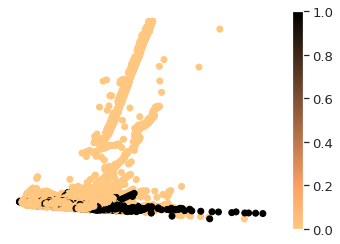

In [89]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_scaled = scaler.fit_transform(X_train)         
PCA_train_x = PCA(2).fit_transform(train_scaled)
plt.scatter(PCA_train_x[:, 0], PCA_train_x[:, 1], c=y_train, cmap="copper_r")
plt.axis('off')
plt.colorbar()
plt.show()

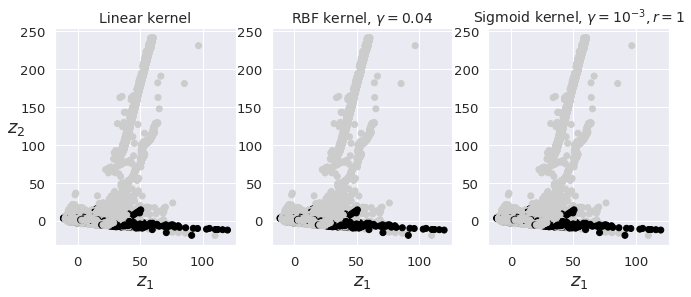

In [90]:
from sklearn.decomposition import KernelPCA

lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)


plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), 
                            (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
       
    PCA_train_x = PCA(2).fit_transform(train_scaled)
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(PCA_train_x[:, 0], PCA_train_x[:, 1], c=y_train, cmap="nipy_spectral_r")
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()

In [91]:
del train_scaled,PCA_train_x,scaler, lin_pca,rbf_pca, sig_pca
gc.collect()

11450

In [92]:
xgb.XGBClassifier(
        n_estimators=500,
        max_depth=9,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        gamma = 0.1,
        alpha = 4,
        missing = -1,
        tree_method='gpu_hist'
)

XGBClassifier(alpha=4, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0.1,
              learning_rate=0.05, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=-1, n_estimators=500, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.9, tree_method='gpu_hist', verbosity=1)

In [93]:
%%time
NFOLDS = 5
kf = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=123)

y_preds = np.zeros(X_test.shape[0])
y_oof = np.zeros(X_train.shape[0])
score = 0
  
for fold, (tr_idx, val_idx) in enumerate(kf.split(X_train, y_train)):
    clf = xgb.XGBClassifier(
        n_estimators=500,
        max_depth=9,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        gamma = 0.2,
        alpha = 4,
        missing = -1,
        tree_method='gpu_hist'
    )
    
    X_tr, X_vl = X_train.iloc[tr_idx, :], X_train.iloc[val_idx, :]
    y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    clf.fit(X_tr, y_tr)
    y_pred_train = clf.predict_proba(X_vl)[:,1]
    y_oof[val_idx] = y_pred_train
    print("FOLD: ",fold,' AUC {}'.format(roc_auc_score(y_vl, y_pred_train)))
    score += roc_auc_score(y_vl, y_pred_train) / NFOLDS
    y_preds+= clf.predict_proba(X_test)[:,1] / NFOLDS
    
    del X_tr, X_vl, y_tr, y_vl
    gc.collect()
    
    
print("\nMEAN AUC = {}".format(score))
print("OOF AUC = {}".format(roc_auc_score(y_train, y_oof)))

FOLD:  0  AUC 0.9652431189175945
FOLD:  1  AUC 0.9670920008187104
FOLD:  2  AUC 0.965193384879283
FOLD:  3  AUC 0.9652659229416958
FOLD:  4  AUC 0.9652960867804649

MEAN AUC = 0.9656181028675497
OOF AUC = 0.9656150292719192
CPU times: user 2min 18s, sys: 48 s, total: 3min 6s
Wall time: 3min 6s


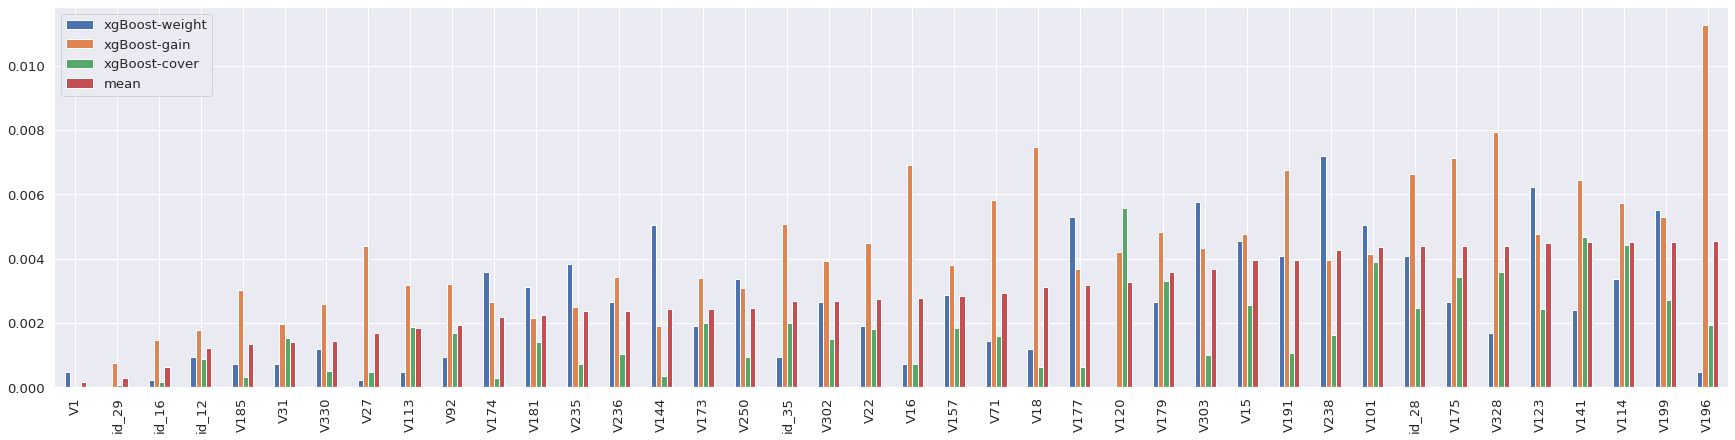

In [94]:
# Get xgBoost importances
importance_dict = {}
for import_type in ['weight', 'gain', 'cover']:
    importance_dict['xgBoost-'+import_type] = clf.get_booster().get_score(importance_type=import_type)
    
# MinMax scale all importances
importance_df = pd.DataFrame(importance_dict).fillna(0)
importance_df = pd.DataFrame(
    preprocessing.MinMaxScaler().fit_transform(importance_df),
    columns=importance_df.columns,
    index=importance_df.index
)

# Create mean column
importance_df['mean'] = importance_df.mean(axis=1)

# Plot the feature importances
importance_df.sort_values('mean').head(40).plot(kind='bar', figsize=(30, 7))